In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.multioutput import MultiOutputRegressor
import sklearn
from random import random
from sklearn.model_selection import cross_validate
import matplotlib
from waveform_methods import binning
import pandas as pd

from scipy.stats import norm
from sklearn.base import clone
import pickle
from statistics import mode
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [2]:
file = uproot.open('/home/andy/12360.root')
file2 = uproot.open('/home/andy/12362.root')

In [3]:
print(file['LaputopParams'].keys())

[b'Run', b'Event', b'SubEvent', b'SubEventStream', b'SubEventStream_String', b'exists', b's125', b'beta', b'age', b'A', b'D', b'N', b'xc_err', b'yc_err', b'ny_err', b'nx_err', b'tc_err', b'log10_s125_err', b'beta_err', b'A_err', b'D_err', b'N_err', b's50', b's70', b's80', b's100', b's150', b's180', b's250', b's500', b'e_proton', b'e_iron', b'e_h4a', b'llh', b'llh_silent', b'chi2', b'chi2_time', b'ndf', b'rlogl', b'nmini']


In [4]:
Xmax1 = file['MCPrimaryInfo']['ghMaxDepth'].array()
valueDepth = file['MCPrimaryInfo']['longNumCharged'].array()
Depth1 = file['MCPrimaryInfo']['longDepth'].array()
chi2_1 = file['CurvatureOnlyParams']['chi2_time'].array()
red1 = file['MCPrimaryInfo']['ghRedChiSqr'].array()
mass1 = [1 for i in range(len(red1))]
        
Xmax2 = file2['MCPrimaryInfo']['ghMaxDepth'].array()
valueDepth = file2['MCPrimaryInfo']['longNumCharged'].array()
Depth2 = file2['MCPrimaryInfo']['longDepth'].array()
chi2_2 = file2['CurvatureOnlyParams']['chi2_time'].array()
red2 = file2['MCPrimaryInfo']['ghRedChiSqr'].array()
mass2 = [4 for i in range(len(red2))]


In [5]:
S125_1 = file['LaputopParams']['s125'].array()
S125_2 = file2['LaputopParams']['s125'].array()
A1 = file['CurvatureOnlyParams']['A'].array()
A2 = file2['CurvatureOnlyParams']['A'].array()
D1 = file['CurvatureOnlyParams']['D'].array()
D2 = file2['CurvatureOnlyParams']['D'].array()
N1 = file['CurvatureOnlyParams']['N'].array()
N2 = file2['CurvatureOnlyParams']['N'].array()
beta1 = file['LaputopParams']['beta'].array()
beta2 = file2['LaputopParams']['beta'].array()
zenith1 = file['Laputop']['zenith'].array()
zenith2 = file2['Laputop']['zenith'].array()
energy1 = file['MCPrimary']['energy'].array()
energy2 = file2['MCPrimary']['energy'].array()

slc_charge1 = file['LaputopSLCPE']['charge'].array()
slc_charge2 = file2['LaputopSLCPE']['charge'].array()

slc_charge1 = [np.sum(i) for i in slc_charge1]
slc_charge2 = [np.sum(i) for i in slc_charge2]

hlc_charge1 = file['LaputopHLCPE']['charge'].array()
hlc_charge2 = file2['LaputopHLCPE']['charge'].array()

hlc_charge1 = [np.sum(i) for i in hlc_charge1]
hlc_charge2 = [np.sum(i) for i in hlc_charge2]

Qtot1 = [i+j for i,j in zip(slc_charge1,hlc_charge1)]
Qtot2 = [i+j for i,j in zip(slc_charge2,hlc_charge2)]

In [6]:
good1 = []
good2 = []
for i in range(len(Xmax1)):
    if ((Xmax1[i] < 900 and Xmax1[i] > 400) and red1[i] < 300) and chi2_1[i] < 5:
        good1.append(True)
    else:
        good1.append(False)
for i in range(len(Xmax2)):
    if ((Xmax2[i] < 650 and Xmax2[i] > 350) and red2[i] < 300) and chi2_2[i] < 5:
        good2.append(True)
    else:
        good2.append(False)
goodness = np.append(good1,good2)

In [7]:
A = np.append(A1,A2)
D = np.append(D1,D2)
N = np.append(N1,N2)
S125 = np.log10(np.append(S125_1,S125_2))
beta = np.log10(np.append(beta1,beta2))
chi2 = np.append(chi2_1,chi2_2)
red = np.append(red1,red2)
zenith = np.cos(np.append(zenith1,zenith2))
Xmax = np.append(Xmax1,Xmax2)
red = np.append(red1,red2)
mass = np.append(mass1,mass2)
slc_charge = np.append(slc_charge1,slc_charge2)
hlc_charge = np.append(hlc_charge1,hlc_charge2)
qtot = np.append(Qtot1,Qtot2)

energy = np.log10(np.append(energy1,energy2))

In [8]:
print(np.corrcoef(np.array([goodness,
                            A,
                            D,
                            N,
                            S125,
                            beta,
                            zenith,
                            chi2,
                            slc_charge,
                            hlc_charge,
                            qtot
                            ])))

[[ 1.         -0.23804063  0.04523001 -0.03347653 -0.1418345   0.1596781
   0.30862365 -0.09058199 -0.25571745 -0.10549331 -0.10721217]
 [-0.23804063  1.          0.30749226 -0.05110983 -0.04803924  0.10285016
   0.21427943  0.25611665 -0.17587495 -0.02263975 -0.02387857]
 [ 0.04523001  0.30749226  1.         -0.0435993  -0.52563202  0.06855834
   0.02395401  0.06673223 -0.29069457 -0.28323046 -0.28499912]
 [-0.03347653 -0.05110983 -0.0435993   1.          0.08137576 -0.0860212
  -0.10458563  0.42102965  0.09735157  0.17207572  0.1725804 ]
 [-0.1418345  -0.04803924 -0.52563202  0.08137576  1.          0.07575187
   0.19535921 -0.05334439  0.29415277  0.67920189  0.68054609]
 [ 0.1596781   0.10285016  0.06855834 -0.0860212   0.07575187  1.
   0.41891977 -0.02705426 -0.23786647  0.08239393  0.08059021]
 [ 0.30862365  0.21427943  0.02395401 -0.10458563  0.19535921  0.41891977
   1.         -0.0246141  -0.46548541  0.1375796   0.13407672]
 [-0.09058199  0.25611665  0.06673223  0.42102965 -

In [9]:
in_value = np.array(list(zip(A,zenith,slc_charge)))
out_value = goodness

In [11]:
skf = StratifiedKFold(n_splits=5,shuffle=True)

for j in [7]:
    rng = np.random.RandomState(1)
    value_0 = []
    value_1 = []
    for train_index, test_index in skf.split(in_value, out_value):
        regr_1 = None
        for i in range(1,120):
            if regr_1 is None:
                regr_1 = BaggingClassifier(DecisionTreeClassifier(max_depth=j,splitter='random',class_weight='balanced'),
                                            n_estimators=i, random_state=rng, warm_start= True,n_jobs=5)
            else:
                regr_1.set_params(n_estimators=i)
            regr_1.fit(in_value[train_index],out_value[train_index])
        predicted_value = regr_1.predict(in_value[test_index])
        cm = confusion_matrix(out_value[test_index],predicted_value)
        value_0.append(cm[0][0]/np.sum(cm[0]))
        value_1.append(cm[1][1]/np.sum(cm[1]))
    
    print(np.mean(value_0),np.mean(value_1),j)

0.6094304869962426 0.8080415421658784 7


In [12]:
import pickle
pickle.dump(regr_1,open('cut_model.sav','wb'))

In [13]:
A = np.append(A1,A2)[goodness]
D = np.append(D1,D2)[goodness]
N = np.append(N1,N2)[goodness]
S125 = np.append(S125_1,S125_2)[goodness]
beta = np.append(beta1,beta2)[goodness]
chi2 = np.append(chi2_1,chi2_2)[goodness]
red = np.append(red1,red2)[goodness]
zenith = np.append(zenith1,zenith2)[goodness]
Xmax = np.append(Xmax1,Xmax2)[goodness]
red = np.append(red1,red2)[goodness]
mass = np.append(mass1,mass2)[goodness]
slc_charge = np.append(slc_charge1,slc_charge2)[goodness]
hlc_charge = np.append(hlc_charge1,hlc_charge2)[goodness]
qtot = np.append(Qtot1,Qtot2)

qtot = qtot[goodness]

energy = np.append(energy1,energy2)[goodness]


In [14]:
print(np.corrcoef(np.array([mass,
                            Xmax,
                            A,
                            D,
                            N,
                            S125,
                            beta,
                            zenith,
                            chi2,
                            red,
                            slc_charge,
                            hlc_charge,
                            qtot
                            ])))

[[ 1.         -0.64282029 -0.21092703 -0.19323613  0.17810721  0.05431741
  -0.22669139  0.03163225  0.0338793  -0.09092861  0.33075373  0.0128587
   0.01503749]
 [-0.64282029  1.          0.21126592 -0.01678903 -0.08192903  0.22539794
   0.18288228  0.13488031 -0.00936622  0.23852132 -0.01668488  0.22532754
   0.22487396]
 [-0.21092703  0.21126592  1.          0.13687349 -0.52459959  0.01292243
   0.16719012 -0.31545461  0.52710483 -0.07086747 -0.12246036  0.09394029
   0.09298349]
 [-0.19323613 -0.01678903  0.13687349  1.         -0.07774617 -0.35274112
   0.09464994  0.00674881  0.00416025 -0.15383627 -0.33802291 -0.31256749
  -0.31433879]
 [ 0.17810721 -0.08192903 -0.52459959 -0.07774617  1.          0.32546051
  -0.05909294  0.1329306  -0.46699586  0.10431362  0.17816027  0.37204691
   0.37266523]
 [ 0.05431741  0.22539794  0.01292243 -0.35274112  0.32546051  1.
   0.01827272 -0.16024508 -0.10784569  0.23374124  0.21416328  0.75122345
   0.75150441]
 [-0.22669139  0.18288228  0.16

In [21]:
import random
input_variable2_old = np.array(list(zip(A,D,N,slc_charge,beta)))
output_new_old = mass

validation = []
output = []

for i in range(len(input_variable2_old)):
    if random.random() < 0.1:
        validation.append(i)
    else:
        output.append(i)
        
validation_x = input_variable2_old[validation]
validation_y = output_new_old[validation]
input_variable = np.array(input_variable2_old)[output]
output_new = np.array(output_new_old)[output]

In [22]:
skf = StratifiedKFold(n_splits=5,shuffle=True)

#23 without any filters
for j in range(1,30):
    rng = np.random.RandomState(1)
    proton = []
    iron = []
    for train_index, test_index in skf.split(input_variable, output_new):
        regr_2 = None
        for i in range(1,120):
            if regr_2 is None:
                regr_2 = BaggingClassifier(DecisionTreeClassifier(max_depth=j,splitter='random',class_weight='balanced'),
                                            n_estimators=i, random_state=rng, warm_start= True,n_jobs=5)
            else:
                regr_2.set_params(n_estimators=i)
            regr_2.fit(input_variable[train_index],output_new[train_index])
        predicted_value = regr_2.predict(input_variable[test_index])
        cm = confusion_matrix(output_new[test_index],predicted_value)
        proton.append(cm[0][0]/np.sum(cm[0]))
        iron.append(cm[1][1]/np.sum(cm[1]))
    
    print(np.mean(proton),np.mean(iron),j)

0.6815851008487371 0.6601351731709512 1
0.7053540117520153 0.6536452350379591 2
0.7168252710212928 0.6534525721012516 3
0.7188911326930861 0.6582515297305778 4
0.7244568792705783 0.6639027691669538 5


KeyboardInterrupt: 

In [55]:
import pickle
pickle.dump(regr_2,open('model.sav','wb'))

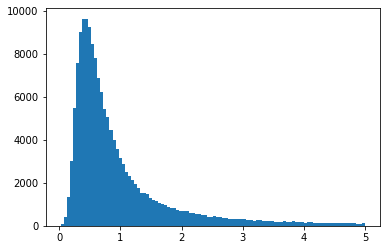

In [39]:
plt.hist(chi2[output],bins=100)
plt.show()